**R-CNN implimetation**                                                         
In this notebook we will learn to impliment R-CNN network on airplane detection task, using some of the popular deep-learning frameworks.  

**Mounting Gdrive**
In the below tab we are going to mount our google drive to reach particular directories and load data


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Installing tensorflow2.0.0**

In [1]:
!pip install tensorflow==2.0.0-beta0

     |████████████████████████████████| 87.9MB 35kB/s 
     |████████████████████████████████| 501kB 34.2MB/s 
     |████████████████████████████████| 3.1MB 33.8MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


Check Tensorflow Version

In [3]:
import tensorflow as tf
tf.__version__

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

'2.0.0-beta0'

Changing Working Directory to Directory where data is load

In [4]:
cd /content/drive/My Drive/AI content/RCNN-master

/content/drive/My Drive/AI content/RCNN-master


We will start by loading in the packages

In [0]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Using TensorFlow backend.


Run this cell to set the path and annot to the address of your image folder and Airplanes_Annotations folder.

In [0]:
path = "/content/drive/My Drive/AI content/RCNN-master/Images"
annot = "/content/drive/My Drive/AI content/RCNN-master/Airplanes_Annotations"

Our airplane dataset contains two parts   
1) Image part-> Contain pictures of airplanes   
2) Airplanes_Annotations-> Contain information about bounding boxes for the pictures available.     
The next cell will show you an example of a labelled image in the dataset. Feel free to change the value of `Index` below and re-run to see different examples.

airplane_148.jpg


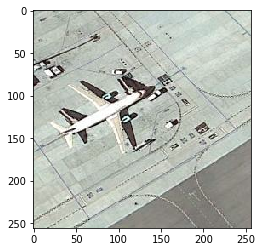

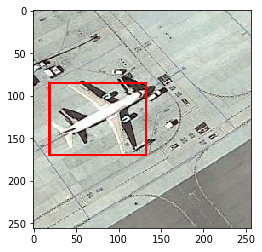

In [0]:
        Index=148
        filename = "airplane_"+str(Index)+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,filename.replace(".jpg",".csv")))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)

**Let's start**                   
R-CNN object detection system consists of three modules. The first generates category-independent region proposals(through selective search here). These proposals define the set of candidate detections available to our detector. The second module is a large convolutional neural network that extracts a fixed-length feature
vector from each region(here we use VGG 16 whereas original paper works on AlexNet). The third module is a set of class specific linear SVMs. So, let's implient them step by step.
![alt text](https://miro.medium.com/max/2372/0*Sdj6sKDRQyZpO6oH.)

**Selective search**                                                    
Selective Search is a region proposal algorithm used in object detection. It is designed to be fast with a very high recall. It is based on computing hierarchical grouping of similar regions based on color, texture, size and shape compatibility.

![alt text](https://arthurdouillard.com/figures/selective_search1.png)

To impliment selective search we use cv2 library, to get more insight of it you can follow this [link](https://pypi.org/project/opencv-python/)

In [0]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

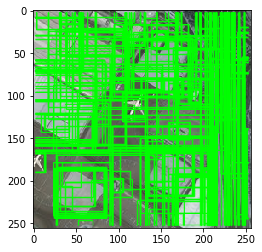

In [0]:
im = cv2.imread(os.path.join(path,"42850.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

Run above cells to get region proposals from selective search algorithm ,performed on a single image to give you more insight of what the algorithm is doing.

**Intersection over union**
Intersection over Union is simply an evaluation metric. Any algorithm that provides predicted bounding boxes as output can be evaluated using IoU.          
More formally, in order to apply Intersection over Union to evaluate an (arbitrary) object detector we need:                                
1.The ground-truth bounding boxes (i.e., the hand labeled bounding boxes from the testing set that specify where in the image our object is).
2.The predicted bounding boxes from our model.   
After getting these two we can find there intersection and union area,whih ultimately gives us our IoU.
![alt text](https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png)

In [0]:
def get_iou(bb1, bb2):
  # assuring for proper dimension.
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
  # calculating dimension of common area between these two boxes.
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
  # if there is no overlap output 0 as intersection area is zero.
    if x_right < x_left or y_bottom < y_top:
        return 0.0
  # calculating intersection area.
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
  # individual areas of both these bounding boxes.
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
  # union area = area of bb1_+ area of bb2 - intersection of bb1 and bb2.
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

**Preparing training data**
Training data here is prepared according to following scheme:-   
a) Those boxes which have an IoU greater than 0.7 (original paper it's 0.5) are considered as a positive example.   
b) And boxes with relative low IoU 0.3 are taken to be negative examples.  
Number of regions taken here is 30 positive and 30 negative (original paper have 32 and 96 respectively) of size 224x224.
Note- Original paper also talk about warping but as we have resized them already so there is no need of it.

In [0]:
# At the end of below code we will have our train data in these lists
train_images=[]
train_labels=[]

In [0]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)   # setting given image as base image
            ss.switchToSelectiveSearchFast()     # running selective search on bae image 
            ssresults = ss.process()     # processing to get the outputs
            imout = image.copy()   
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:     # till 2000 to get top 2000 regions only
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})  # calculating IoU for each of the proposed regions
                        if counter < 30:       # getting only 30 psoitive examples
                            if iou > 0.70:     # IoU or being positive is 0.7
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1              # to insure we have collected all psotive examples
                        if falsecounter <30:      # 30 negatve examples are allowed only
                            if iou < 0.3:         # IoU or being negative is 0.3
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1             #to ensure we have collected all negative examples
                    if fflag == 1 and bflag == 1:  
                        print("inside")
                        flag = 1        # to signal the complition of data extaction from a particular image
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_283.jpg
1 airplane_217.jpg
2 airplane_308.jpg
3 airplane_055.jpg
4 airplane_103.jpg
5 airplane_076.jpg
6 airplane_077.jpg
7 airplane_277.jpg
8 airplane_038.jpg
10 airplane_186.jpg
12 airplane_126.jpg
inside
14 airplane_096.jpg
inside
15 airplane_215.jpg
16 airplane_203.jpg
17 airplane_198.jpg
18 airplane_028.jpg
19 airplane_062.jpg
inside
20 airplane_313.jpg
21 airplane_255.jpg
22 airplane_040.jpg
23 airplane_135.jpg
24 airplane_064.jpg
25 airplane_274.jpg
26 airplane_117.jpg
27 airplane_012.jpg
inside
28 airplane_112.jpg
inside
29 airplane_142.jpg
30 airplane_265.jpg
31 airplane_226.jpg
32 airplane_078.jpg
33 airplane_221.jpg
34 airplane_200.jpg
35 airplane_124.jpg
36 airplane_232.jpg
37 airplane_210.jpg
38 airplane_156.jpg
39 airplane_242.jpg
41 airplane_056.jpg
42 airplane_177.jpg
44 airplane_146.jpg
45 airplane_149.jpg
46 airplane_023.jpg
47 airplane_140.jpg
48 airplane_318.jpg
49 airplane_191.jpg
50 airplane_158.jpg
51 airplane_185.jpg
52 airplane_132.jpg
53 airplane_08

KeyboardInterrupt: ignored

In [0]:
# conversion of train data into arrays for further training
X_new = np.array(train_images)
Y_new = np.array(train_labels)

**Load packages**  
let's load the requied packages

In [0]:
from keras.layers import Dense
from keras import Model
from keras import optimizers

**Pre-training**  
We perform tansfer-learning, as pre-training here as we are using VGG16 net which is already trained on Imagenet.  We are going to train a binary classifier by making all layers as untrainble except two last.    And then we are going to make a new model which will be stacked on last 2nd output layer.


In [6]:
vgg = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
for layer in vgg.layers[:-2]:
  layer.trainable = False
x = vgg.get_layer('fc2')
last_output =  x.output
x = tf.keras.layers.Dense(1,activation = 'sigmoid')(last_output)  
model = tf.keras.Model(vgg.input,x)
model.compile(optimizer = "adam", 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])



553467904/553467096 [==============================] - 7s 0us/step


**Summary of the model and Training**

In [0]:
model.summary()
model.fit(X_new,Y_new,batch_size = 64,epochs = 3, verbose = 1,validation_split=.05,shuffle = True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

KeyboardInterrupt: ignored

**Making New Network with svm**

We will start with first creating the dataset for the svm and then making the architecture

In [0]:
svm_image = [];
svm_label = [];

**SVM Dataset**    
For svm dataset we considered all the bounding boxes as positive examples and and those which were having an IOU less than 0.3 as false examples to increase the preciseness.

In [0]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3]) 
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
                timage = image[x1:x2,y1:y2]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                svm_image.append(resized)
                svm_label.append([0,1])
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if falsecounter <5:
                            if iou < 0.3:
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                svm_image.append(resized)
                                svm_label.append([1,0])
                                falsecounter += 1
                        else :
                            flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_283.jpg
1 airplane_217.jpg
2 airplane_308.jpg
3 airplane_055.jpg
4 airplane_103.jpg
5 airplane_076.jpg
6 airplane_077.jpg
7 airplane_277.jpg
8 airplane_038.jpg
10 airplane_186.jpg
12 airplane_126.jpg
14 airplane_096.jpg
15 airplane_215.jpg
16 airplane_203.jpg
17 airplane_198.jpg
18 airplane_028.jpg
19 airplane_062.jpg
20 airplane_313.jpg
21 airplane_255.jpg
22 airplane_040.jpg
23 airplane_135.jpg
24 airplane_064.jpg
25 airplane_274.jpg
26 airplane_117.jpg
27 airplane_012.jpg
28 airplane_112.jpg
29 airplane_142.jpg
30 airplane_265.jpg
31 airplane_226.jpg
32 airplane_078.jpg
33 airplane_221.jpg
34 airplane_200.jpg
35 airplane_124.jpg
36 airplane_232.jpg
37 airplane_210.jpg
38 airplane_156.jpg
39 airplane_242.jpg
41 airplane_056.jpg
42 airplane_177.jpg
44 airplane_146.jpg
45 airplane_149.jpg
46 airplane_023.jpg
47 airplane_140.jpg
48 airplane_318.jpg
49 airplane_191.jpg
50 airplane_158.jpg
51 airplane_185.jpg
52 airplane_132.jpg
53 airplane_081.jpg
54 airplane_016.jpg
55 airpla

**SVM Model Architecture**  
First we removed the last layer of the previous model and then added a Dense layer of 2 units at the end of 'fc2' layer and as previous only the last layer is trainable.

Now we will see our new Moel Summary and we will train it which is final one.

In [10]:
cd "/content/drive/My Drive/AI content/RCNN-master"

/content/drive/My Drive/AI content/RCNN-master


In [9]:
#adding svm to last layer
x =model.get_layer('fc2').output
Y = tf.keras.layers.Dense(2)(x)
final_model = tf.keras.Model(model.input,Y)
final_model.compile(loss='hinge',
              optimizer='adam',
              metrics=['accuracy'])
final_model.summary()
final_model.load_weights('my_model_weights.h5')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

ValueError: ignored

In [0]:
hist_final = final_model.fit(np.array(svm_image),np.array(svm_label),batch_size=32,epochs = 20,verbose = 1,shuffle = True,validation_split = 0.05)

Train on 5339 samples, validate on 281 samples
Epoch 1/20
5152/5339 [===========================>..] - ETA: 42s - loss: 3.5488 - accuracy: 0.6656

**Ploting  loss and analysing losses**

In [0]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist_final.history['loss'])
plt.plot(hist_final.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

**Test Time Bro**  
By Running the below cell we can get the bounding boxes of a particular image and can cherish ourselves.

0 [[190.19203   -8.590889]]
1 [[2.0671539e+02 4.2925436e-02]]
2 [[205.98946 -11.59219]]
3 [[264.0965     -1.8803713]]
4 [[283.49036  -14.864341]]
5 [[221.53862     3.0138063]]
6 [[232.50168   -9.385057]]
7 [[239.70956   -7.774951]]
8 [[226.34889  -8.94477]]
9 [[221.95245  -11.047145]]
10 [[184.74463   -4.596522]]
11 [[201.17294   -6.392091]]
12 [[209.76025  -13.512845]]
13 [[210.86354  -11.524303]]
14 [[236.26459  -14.764219]]
15 [[258.2867    -4.033795]]
16 [[242.7969     -4.7574563]]
17 [[254.81413 -20.88265]]
18 [[226.90244    -7.2612915]]
19 [[236.03885  -14.587179]]
20 [[215.09308     2.6984577]]
21 [[246.31256   -5.315984]]
22 [[205.0851   -12.201444]]
23 [[200.2342   -4.78049]]
24 [[208.90846   -9.441244]]
25 [[286.70764   -8.756268]]
26 [[187.90889    -7.2846074]]
27 [[232.27153 -10.61375]]
28 [[185.19197   -9.359203]]
29 [[245.02292     1.9483603]]
30 [[210.55861   -7.491072]]
31 [[261.4725    -8.497118]]
32 [[222.69702  -14.292775]]
33 [[186.84355   -7.507931]]
34 [[203.87976

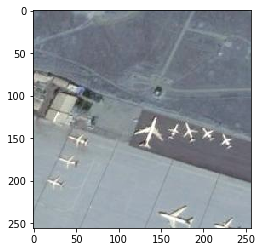

In [0]:
###########  it's time for test a image    ##########
image = cv2.imread(os.path.join(path,'airplane_020.jpg'))
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()

imOut = image.copy()
boxes = []
count = 0
for e,result in enumerate(ssresults):
  if e < 50:
    x,y,w,h = result
    timage = imout[x:x+w,y:y+h]
    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
    resized = np.expand_dims(resized,axis = 0)
    out = final_model.predict(resized)
    print(e,out)
    if(out[0][0]<out[0][1]):
      boxes.append([x,y,w,h])
      count+=1

for box in boxes:
    x, y, w, h = box
    print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)